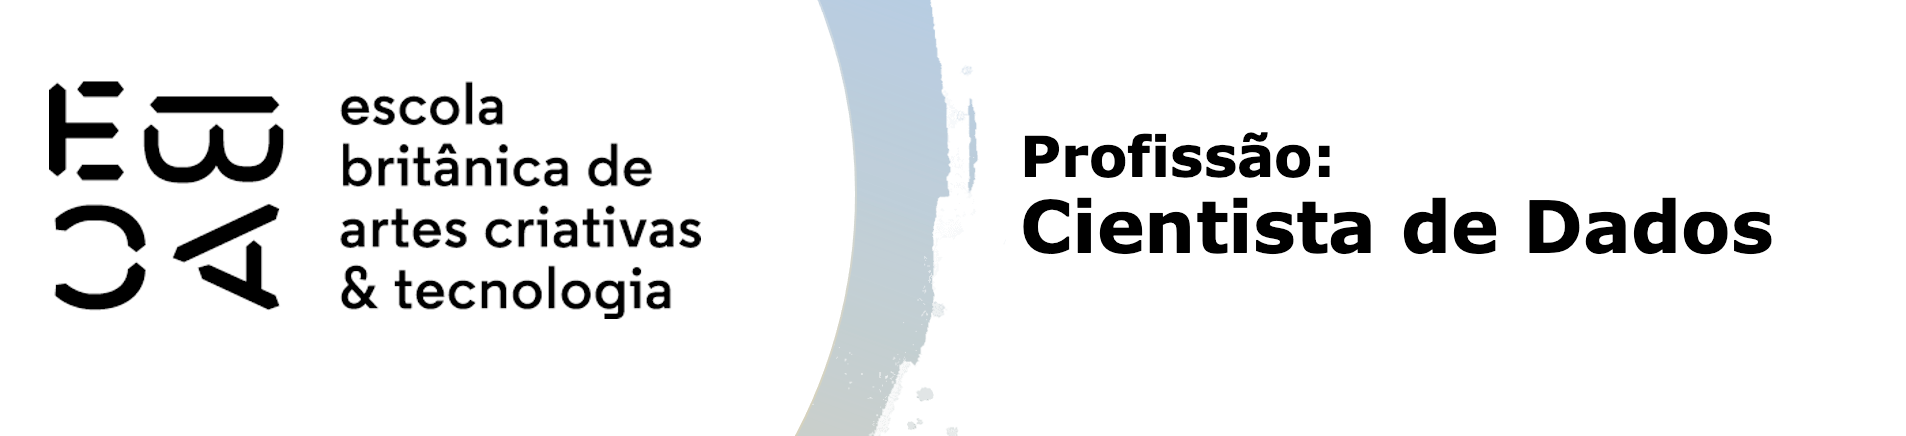

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelo de previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [59]:
import patsy
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy.interpolate import interp1d

import warnings;   warnings.filterwarnings("ignore")

In [60]:
# Dados
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [61]:
# Valores missing
print('Verificando valores faltantes:')
display(df.isnull().sum())
display(df.info())

Verificando valores faltantes:


index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 2015-01-01 to 2016-03-01
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  750000 non-null  int64  
 1   sexo                   750000 non-null  object 
 2   posse_de_veiculo       750000 non-null  object 
 3   posse_de_imovel        750000 non-null  object 
 4   qtd_filhos             750000 non-null  int64  
 5   tipo_renda             750000 non-null  object 
 6   educacao               750000 non-null  object 
 7   estado_civil           750000 non-null  object 
 8   tipo_residencia        750000 non-null  object 
 9   idade                  750000 non-null  int64  
 10  tempo_emprego          624240 non-null  float64
 11  qt_pessoas_residencia  750000 non-null  float64
 12  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 80.1+ MB


None

In [62]:
# Substituindo os valores missing pela média
df['tempo_emprego'].fillna(value=df['tempo_emprego'].mean(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 2015-01-01 to 2016-03-01
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  750000 non-null  int64  
 1   sexo                   750000 non-null  object 
 2   posse_de_veiculo       750000 non-null  object 
 3   posse_de_imovel        750000 non-null  object 
 4   qtd_filhos             750000 non-null  int64  
 5   tipo_renda             750000 non-null  object 
 6   educacao               750000 non-null  object 
 7   estado_civil           750000 non-null  object 
 8   tipo_residencia        750000 non-null  object 
 9   idade                  750000 non-null  int64  
 10  tempo_emprego          750000 non-null  float64
 11  qt_pessoas_residencia  750000 non-null  float64
 12  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 80.1+ MB


In [63]:
# Bases de treino e teste 
df_train = df[:'2015-12-01']
df_test = df['2016-01-01':]

print('\033[1mDatas para dados de df_train:\033[0m')
display(df_train.index.unique())
print('\n\033[1mDatas para dados de df_test:\033[0m')
display(df_test.index.unique())

Datas para dados de df_train:


Index(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01',
       '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01',
       '2015-11-01', '2015-12-01'],
      dtype='object', name='data_ref')


Datas para dados de df_test:


Index(['2016-01-01', '2016-02-01', '2016-03-01'], dtype='object', name='data_ref')

In [64]:
# Criando log_renda
df_train['log_renda'] = np.log(df_train['renda'])
df_test['log_renda'] = np.log(df_test['renda'])

In [65]:
cr = df_train.drop(['index','renda','sexo','tipo_residencia'], axis=1)

df_encoded = pd.get_dummies(cr, columns=['posse_de_veiculo',
                                         'posse_de_imovel','tipo_renda', 
                                         'educacao', 'estado_civil'], prefix=['posse_de_veiculo',
                                                                     'posse_de_imovel','tipo_renda', 
                                                                     'educacao', 'estado_civil'])

df_encoded.head(3)

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,log_renda,posse_de_veiculo_N,posse_de_veiculo_S,posse_de_imovel_N,posse_de_imovel_S,tipo_renda_Assalariado,...,educacao_Fundamental,educacao_Médio,educacao_Pós graduação,educacao_Superior completo,educacao_Superior incompleto,estado_civil_Casado,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo
data_ref,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0,47,16.717808,2.0,9.318131,False,True,True,False,False,...,False,False,False,True,False,True,False,False,False,False
2015-01-01,0,30,9.600000,2.0,7.793508,False,True,True,False,True,...,False,False,False,False,True,True,False,False,False,False
2015-01-01,0,28,8.208219,2.0,9.528769,False,True,True,False,True,...,False,False,False,True,False,True,False,False,False,False


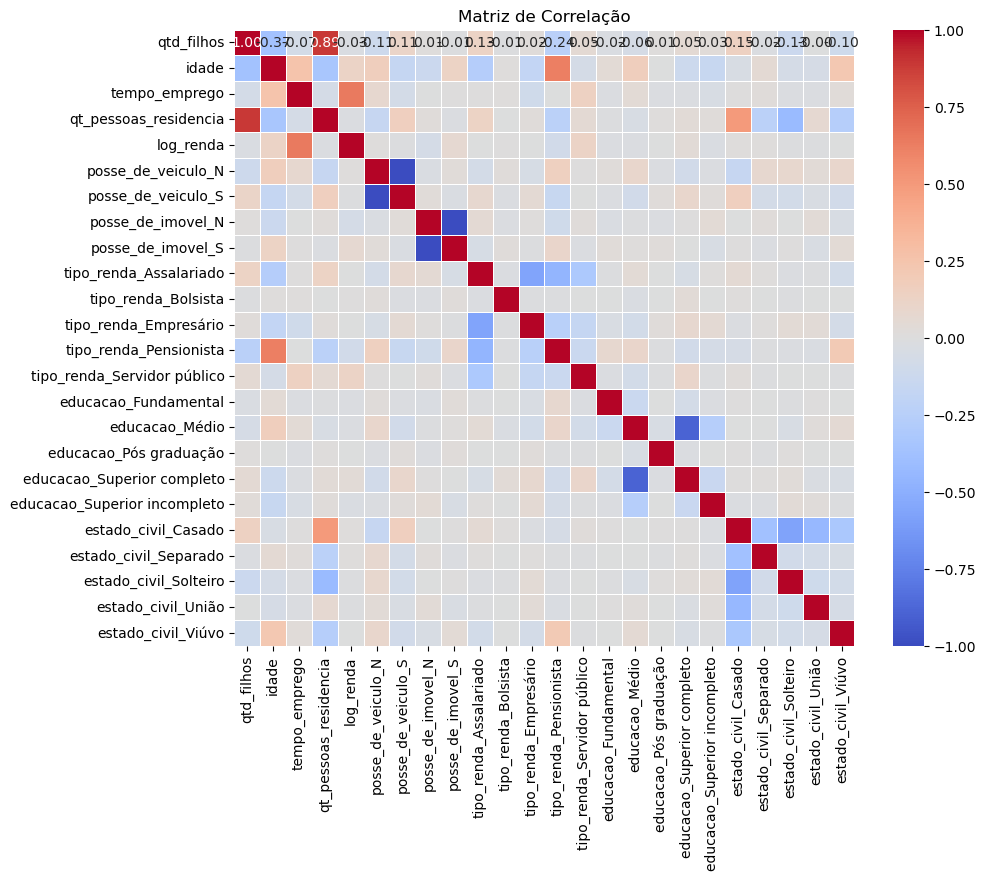

In [66]:
plt.figure(figsize=(10, 8))

sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

In [67]:
# Já é possível observar as variáveis mais relevantes para o modelo LASSO 
X1 = patsy.dmatrices('''log_renda ~ C(posse_de_imovel)
                                    + idade
                                    + C(estado_civil)    
                                    + tempo_emprego''', df_train)

res = smf.ols(X1, data=df_train).fit_regularized(method = 'elastic_net' 
                                                , refit = True
                                                , L1_wt = 1
                                                , alpha = 0.05)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                 1.103e+05
Date:                Thu, 01 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:21:24   Log-Likelihood:            -8.0490e+05
No. Observations:              600000   AIC:                         1.610e+06
Df Residuals:                  599996   BIC:                         1.610e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       8.3826      0.005   1693.373      0.000       8.373       8.392
C(posse_de_imovel)[T.S]         0.1790      0.003     69.703      0.000       0.174       0.184
C(estado_civil)[T.Separado]          0          0        nan        nan           0           0
C(estado_civil)[T.Solteiro]          0          0        nan        nan           0           0
C(estado_civil)[T.União]             0          0        nan        nan           0           0
C(estado_civil)[T.Viúvo]             0          0        nan        nan           0           0
idade                          -0.0056      0.000    -50.285      0.000      -0.006      -0.005
tempo_emprego                   0.1317      0.000    650.147      0.000       0.131       0.132
==============================================================================
Omnibus:                      891.428   Durbin-Watson:                   1.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              795.178
Skew:                          -0.048   Prob(JB):                    2.13e-173
Kurtosis:                       2.850   Cond. No.                         242.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
# Simplicficando o modelo com mesmo valor de R²
X1 = patsy.dmatrices('''log_renda ~ C(posse_de_imovel)
                                    + tempo_emprego''', df_train)

res = smf.ols(X1, data=df_train).fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.05)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.456e+05
Date:                Thu, 01 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:21:35   Log-Likelihood:            -8.0617e+05
No. Observations:              600000   AIC:                         1.612e+06
Df Residuals:                  599997   BIC:                         1.612e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.1700      0.003   3166.772      0.000       8.165       8.175
C(posse_de_imovel)[T.S]     0.1615      0.003     63.353      0.000       0.157       0.167
tempo_emprego               0.1291      0.000    657.553      0.000       0.129       0.129
==============================================================================
Omnibus:                      863.676   Durbin-Watson:                   1.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              773.991
Skew:                          -0.048   Prob(JB):                    8.51e-169
Kurtosis:                       2.853   Cond. No.                         27.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

<Axes: ylabel='log_renda'>

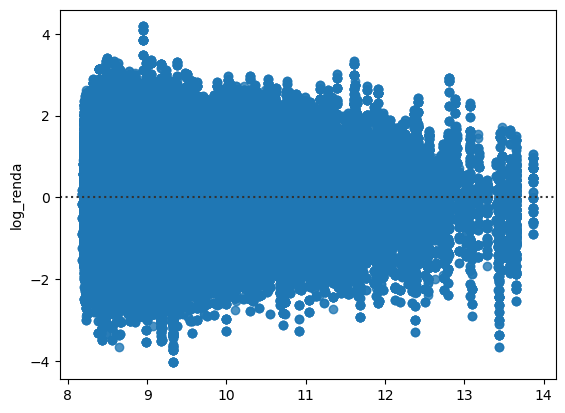

In [69]:
# Dist. Valores preditos X Renda
sns.residplot(x=res.predict(), y='log_renda', data=df_train)

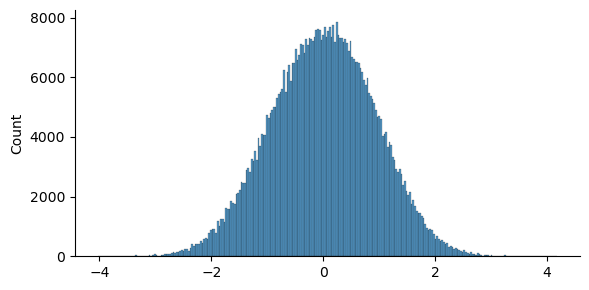

In [70]:
# Distribuição dos resíduos gaussiana
sns.displot(res.resid, height=3, aspect=2);

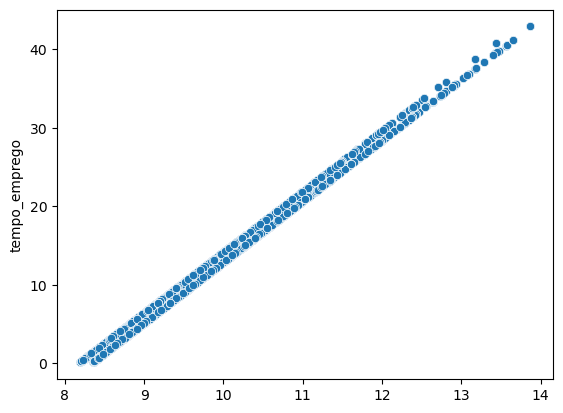

In [71]:
# Distribuição dos valores preditos em relaçãop a variável mais relevante
sns.scatterplot(x = res.predict(), y = 'tempo_emprego', data=df_train);

<Axes: >

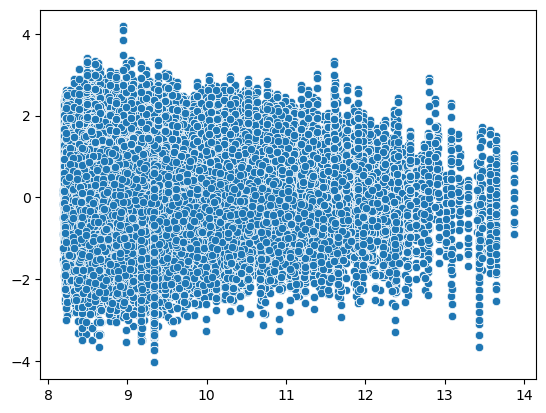

In [72]:
# Predito X Resíduo
sns.scatterplot(x = res.predict(), y = res.resid)

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

In [78]:
# Amostra
df_train_short = df_train[:'2015-02-01']
df_train_short.reset_index(inplace=True)

In [80]:
reg = smf.ols('log_renda ~ tempo_emprego', data=df_train_short).fit()

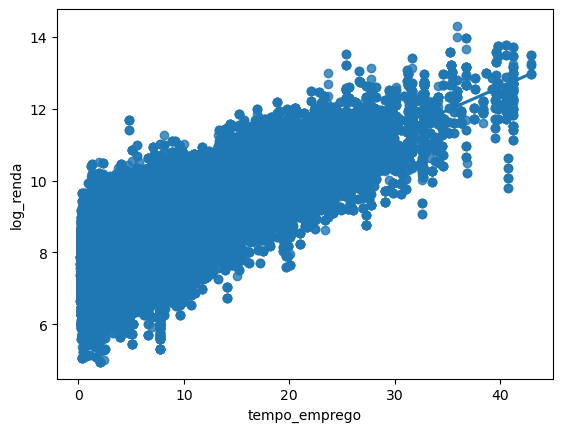

In [81]:
fig, ax = plt.subplots()

sns.regplot(x = 'tempo_emprego', y = 'log_renda', data=df_train_short, ax=ax);

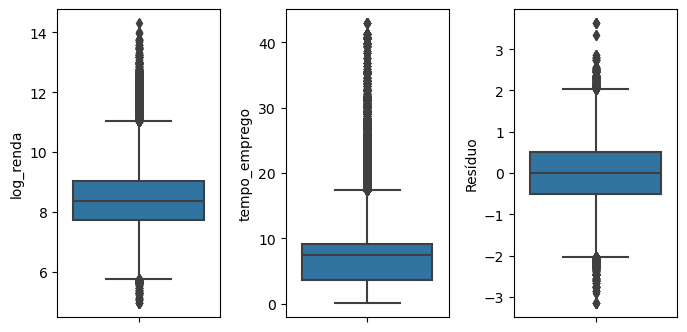

In [82]:
fix, ax = plt.subplots(1, 3, figsize=(8,4))
plt.subplots_adjust(wspace=.4, hspace=0)

sns.boxplot(y = 'log_renda',data=df_train_short, ax=ax[0])
sns.boxplot(y = 'tempo_emprego',data=df_train_short, ax=ax[1])
sns.boxplot(y = reg.resid ,data=df_train_short, ax=ax[2]);

ax[0].set_ylabel('log_renda')
ax[2].set_ylabel('tempo_emprego')
ax[2].set_ylabel('Resíduo');

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

In [96]:
df_train_cut = df_train[['posse_de_imovel', 'tempo_emprego', 'log_renda']]

df_train_select = pd.get_dummies(df_train[['posse_de_imovel', 'tempo_emprego', 'log_renda']])

df_train_select.head(3)

,tempo_emprego,log_renda,posse_de_imovel_N,posse_de_imovel_S
data_ref,,,,
2015-01-01,16.717808,9.318131,True,False
2015-01-01,9.600000,7.793508,True,False
2015-01-01,8.208219,9.528769,True,False


In [97]:
# Matriz de correlação de Spearman

df_train_select.corr(method='spearman')

,tempo_emprego,log_renda,posse_de_imovel_N,posse_de_imovel_S
tempo_emprego,1.000000,0.531836,-0.014221,0.014221
log_renda,0.531836,1.000000,-0.066059,0.066059
posse_de_imovel_N,-0.014221,-0.066059,1.000000,-1.000000
posse_de_imovel_S,0.014221,0.066059,-1.000000,1.000000


In [103]:
# VIF
variaveis = ['tempo_emprego', 'posse_de_imovel']

dum = pd.get_dummies(df_train_cut[variaveis], drop_first=True)
dum = dum.astype(int)

dum.head(4)

,tempo_emprego,posse_de_imovel_S
data_ref,,
2015-01-01,16,0
2015-01-01,9,0
2015-01-01,8,0
2015-01-01,1,1


In [104]:
vif(dum.values, 1)

1.644768052511959

In [105]:
vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(dum, i) for i in range(dum.shape[1])]
vars_vif["Feature"] = dum.columns

vars_vif.round(2)

,VIF Factor,Feature
0,1.64,tempo_emprego
1,1.64,posse_de_imovel_S


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

**Seguindo de acordo com valores da análise VIF, com bons números para suas variáveis. Conforme verificado na distribuição regplot na verificação de Outliers não foi necessário a remoção por não existir valores muito agressivos para o modelo**